This tutorial is about
- Define J1-J2 Hamiltonian
- Define CNN with the ability to learn signs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import quantax as qtx

lattice = qtx.sites.Square(4) # 4x4 square lattice
N = lattice.nsites

In [2]:
from quantax.symmetry import TotalSz, SpinInverse, C4v, Trans2D

# J1=1, J2=0.5, with Marshall sign rule
H = qtx.operator.Heisenberg(J=[1, 0.5], n_neighbor=[1, 2], msr=True)

# use_sinh default to False, in which case the last layer activation is exp(x)
# if use_sinh is True, then the last layer activation is sinh(x) + 1
# use_sinh=True allows to learn the sign structures with real parameters and outputs
net = qtx.nn.ResSum(4, 8, 4, use_sinh=True)

state = qtx.state.Variational(
    net,
    symm=TotalSz(), # specify Sz = 0, important for Heisenberg model
    max_parallel=N*3000, # maximum forward batch on each machine
)

# sampler contains spin exchanges between nearest and next nearest neighbors
sampler = qtx.sampler.NeighborExchange(state, 1000, n_neighbor=[1, 2])
tdvp = qtx.optimizer.TDVP(state, H)

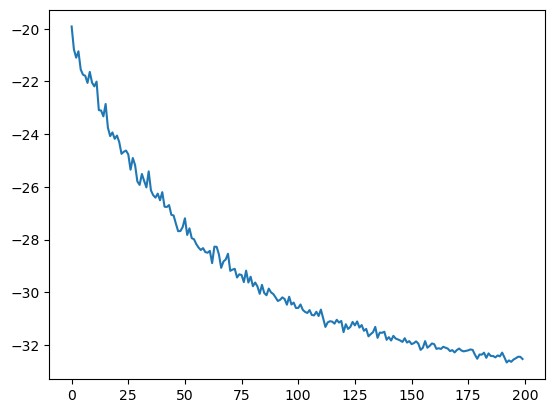

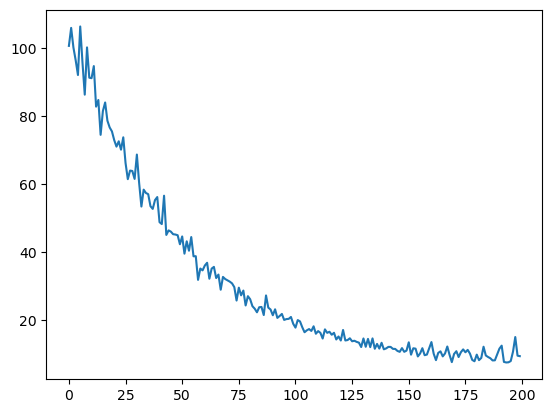

In [3]:
energy_data = qtx.utils.DataTracer()
VarE_data = qtx.utils.DataTracer()

for i in range(200):
    samples = sampler.sweep()
    step = tdvp.get_step(samples)
    state.update(step * 1e-3)
    energy_data.append(tdvp.energy)
    VarE_data.append(tdvp.VarE)

energy_data.plot()
plt.show()
VarE_data.plot()
plt.show()

In [4]:
# symmetrize the trained NQS

symm = TotalSz() + SpinInverse() + C4v()
symm_state = symm(state)

sampler = qtx.sampler.NeighborExchange(symm_state, 1000, n_neighbor=[1, 2])
tdvp = qtx.optimizer.TDVP(symm_state, H)

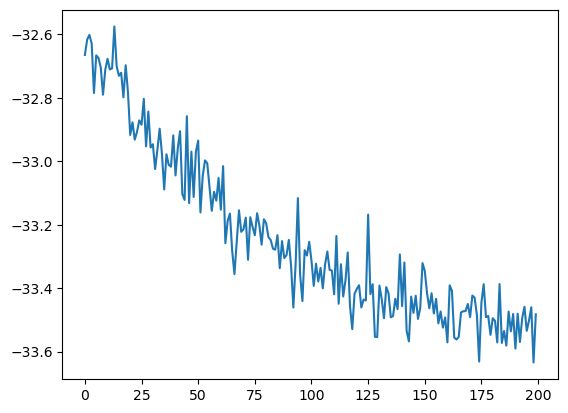

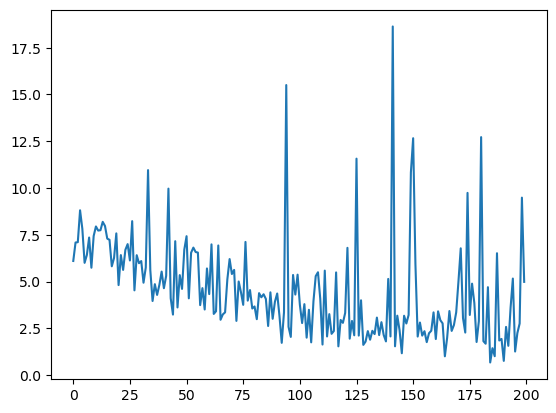

In [5]:
energy_data = qtx.utils.DataTracer()
VarE_data = qtx.utils.DataTracer()

for i in range(200):
    samples = sampler.sweep()
    step = tdvp.get_step(samples)
    symm_state.update(step * 1e-3)
    energy_data.append(tdvp.energy)
    VarE_data.append(tdvp.VarE)

energy_data.plot()
plt.show()
VarE_data.plot()
plt.show()

In [7]:
# check result by ED
full_symm = symm + Trans2D()
E, wf = H.diagonalize(full_symm)
print(E[0])

/home/locao/miniconda3/envs/netket/lib/python3.9/site-packages/quantax/symmetry/symmetry.py:126: GeneralBasisWarning: using non-commuting symmetries can lead to unwanted behaviour of general basis, make sure that quantum numbers are invariant under non-commuting symmetries!
  basis = spin_basis_general(


Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
-33.83169340557929
